# Quick Start

## Introduction
In this tutorial, you will get a quick view of `AiiDA-WorkGraph`. To run this tutorial, you need to install `aiida-workgraph`. Open a terminal and run:

```console
pip install aiida-workgraph
```

Start (or restart) the AiiDA daemon if needed:
```console
verdi daemon start
```

Load the AiiDA profile.

In [1]:
%load_ext aiida
from aiida import load_profile
load_profile()

Profile<uuid='57ccbf7d9e2b41b39edb2bfdaf725feb' name='default'>

## First workflow
Suppose we want to calculate ```(x + y) * z ``` in two steps. First, add `x` and `y`, then multiply the result with `z`.


### Create node
Node is the basic building block of the WorkGraph. A node has inputs, outputs. In AiiDA, one uses the `calcfunction` to do the calculation and generate new data. AiiDA-WorkGraph goes one step further by transforming a `calcfunction` to a `Node`.

In [2]:
from aiida_workgraph import node

# define add node
@node.calcfunction()
def add(x, y):
    return x + y

# define multiply node
@node.calcfunction()
def multiply(x, y):
    return x*y

# visualize the node in Jupiter-notebook
add.node()

NodeGraphWidget(settings={'minmap': False}, style={'width': '40%', 'height': '600px'}, value={'nodes': {'add0'…


#### Visualize the node
If you are running in a Jupiter notebook, you can visualize the node.
<img src="_static/images/add-node.png" width=250 />


The input sockets are generated automatically based on the function arguments. The default name of the output socket is `result`. There are also some built-in sockets for all nodes, like `_wait` and `_outputs`.  In case of `calcfunction`, it also has several built-in sockets, such as `metadata`. One can also create a node instance and inpsect its inputs and outputs:

In [4]:
add1 = add.node()
print("Inputs:", add1.inputs.keys())
print("Outputs:", add1.outputs.keys())

Inputs: ['metadata', 'metadata.store_provenance', 'metadata.description', 'metadata.label', 'metadata.call_link_label', 'x', 'y', '_wait']
Outputs: ['result', '_outputs', '_wait']


If you want to change the name of the output sockets, or if there are more than one output. You must define the outputs explicitly.
For example:

In [6]:
# define add calcfunction node
@node.calcfunction(outputs=[["General", "sum"],
               ["General", "difference"]])
def add_minus(x, y):
   return {"sum": x + y, "difference": x - y}

print("Inputs:", add_minus.node().inputs.keys())
print("Outputs:", add_minus.node().outputs.keys())

Inputs: ['metadata', 'metadata.store_provenance', 'metadata.description', 'metadata.label', 'metadata.call_link_label', 'x', 'y', '_wait']
Outputs: ['sum', 'difference', '_outputs', '_wait']


 Each output is defined by two values: e.g. `["General", "sum"]`, where the first value `General` indicates the data type, and the second value is the name of the socket. The data type tell the code how to display the socket in the GUI and to serialize data into database. We use `General` for any data type.

### Create the workflow
Three steps:

- create a empty `WorkGraph`
- add nodes: `add` and `multiply`.
- link the output of the `add` node to one of the `x` input of the `multiply` node.


#### Visualize the workgraph
If you are running in a Jupiter notebook, you can visualize the workgraph.

<img src="_static/images/first-workflow.png" />

In [7]:
from aiida_workgraph import WorkGraph
from aiida.orm import Int

wg = WorkGraph("first_workflow")
wg.nodes.new(add, name="add", x=Int(2.0), y=Int(3.0))
wg.nodes.new(multiply, name="multiply", y=Int(4.0))
wg.links.new(wg.nodes["add"].outputs[0], wg.nodes["multiply"].inputs["x"])

# visualize the workgraph
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'first_w…

### Submit and view results


In [8]:
wg.submit(wait=True)

print("State of WorkGraph:   {}".format(wg.state))
print('Result of add      : {}'.format(wg.nodes["add"].outputs[0].value))
print('Result of multiply : {}'.format(wg.nodes["multiply"].outputs[0].value))

WorkGraph node created, PK: 32987
State of WorkGraph:   FINISHED
Result of add      : uuid: af9782f8-fd84-42cf-8296-a1c43ebae170 (pk: 32989) value: 5
Result of multiply : uuid: 7ebc5043-8a5b-4cc3-81dd-2e551c524cba (pk: 32991) value: 20


One can also generate the node graph from the AiiDA process:

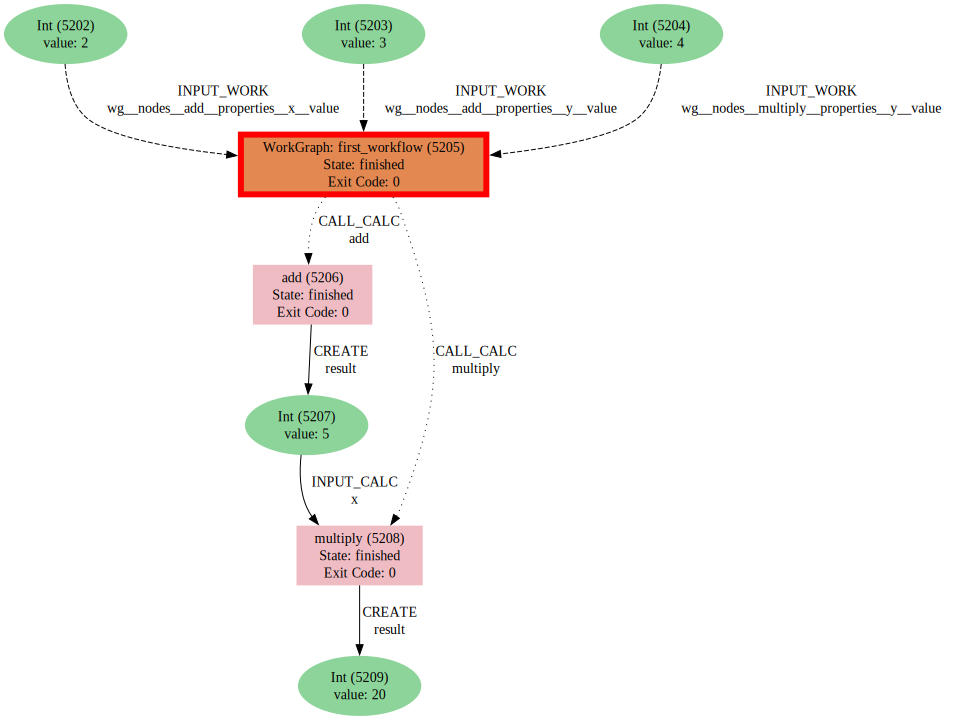

In [ ]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## CalcJob and WorkChain
AiiDA uses `CalcJob` to run a calculation on a remote computer. AiiDA community also provides a lot of well-written `calcfunction` and `WorkChain`. One can use these AiiDA component direclty in the WorkGraph. The inputs and outputs of the node is automatically generated based on the input and output port of the AiiDA component.

Here is an example of using the `ArithmeticAddCalculation` Calcjob inside the workgraph.

In [9]:
from aiida_workgraph import WorkGraph
from aiida.calculations.arithmetic.add import ArithmeticAddCalculation
from aiida.orm import Int, load_code

code = load_code("add@localhost")

wg = WorkGraph("test_add_multiply")
add1 = wg.nodes.new(ArithmeticAddCalculation, name="add1", x=Int(2), y=Int(3), code=code)
add2 = wg.nodes.new(ArithmeticAddCalculation, name="add2", y=Int(3), code=code)
wg.links.new(wg.nodes["add1"].outputs["sum"], wg.nodes["add2"].inputs["x"])
display(wg)
wg.submit(wait=True)

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'test_ad…

WorkGraph node created, PK: 32996


<WorkChainNode: uuid: 370afb81-e731-4752-bc7b-d998adec4fe4 (pk: 32996) (aiida_workgraph.engine.workgraph.WorkGraph)>

Get the result of the nodes:

In [10]:
print('Result of node add1: {}'.format(wg.nodes["add2"].outputs["sum"].value))

Result of node add1: uuid: d6a9a4bc-f18c-4eca-8d09-23dacce944ab (pk: 33004) value: 8


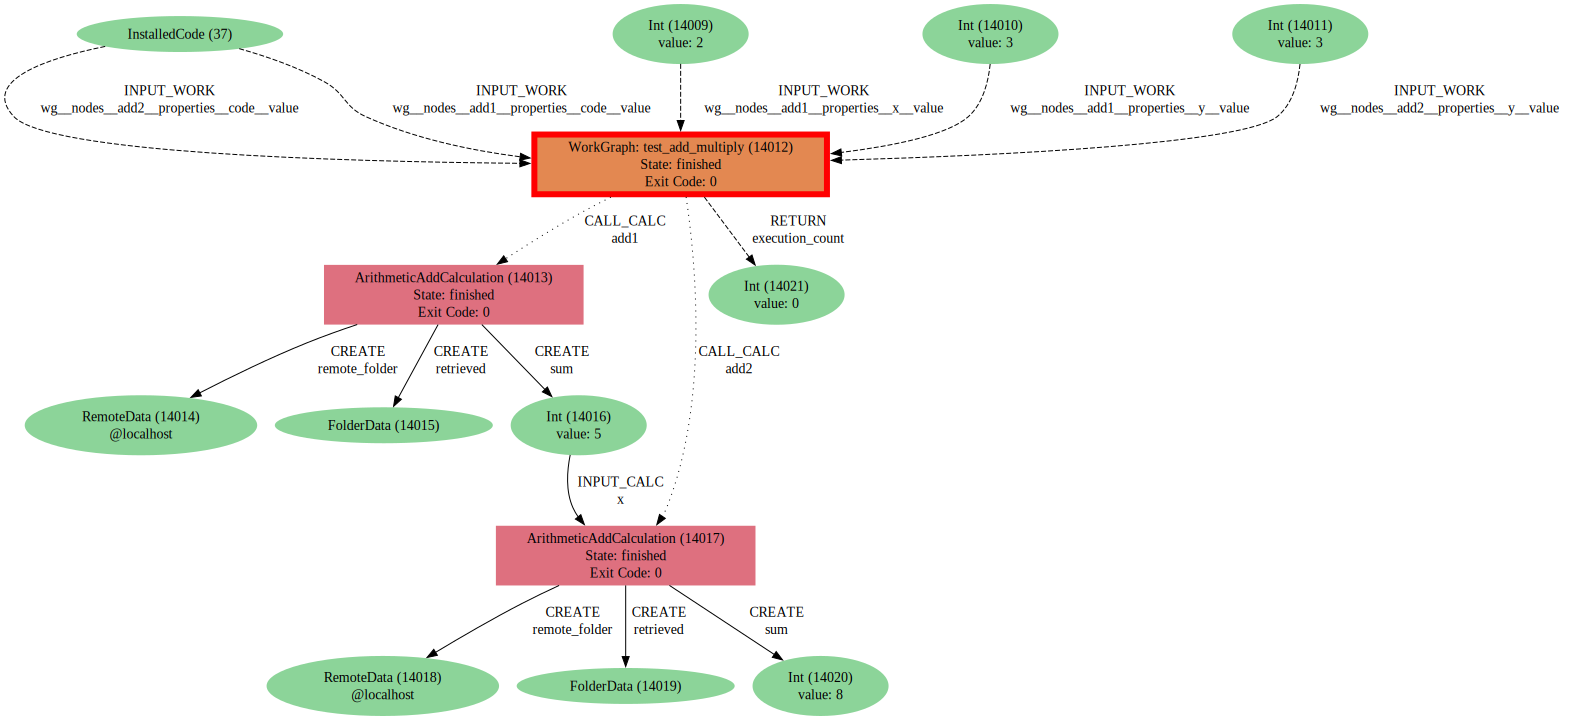

In [5]:
from aiida_workgraph.utils import generate_node_graph

generate_node_graph(wg.pk)

## Graph builder
A `WorkGraph` is a group of nodes. One can treat a `WorkGraph` as a single node, and expose the inputs and outputs of the `WorkGraph`. This allow you to write:

- nested workflows
- dynamic workflow based on the input values. For example, if you want to use `if` and `for` to create the nodes, or repeat a calculation until it converges.

The `Graph Builder` allow user to create a dynamic workflow based on the input value, as well as nested workflows. Here is an example of nested workflow:

In [11]:
from aiida_workgraph import WorkGraph, node

# use node.graph_builder decorator, expose the output of "multiply" node
# as the output of the `WorkGraph`.
@node.graph_builder(outputs = [["multiply.result", "result"]])
def add_multiply(x, y, z):
    # Create a WorkGraph
    wg = WorkGraph()
    wg.nodes.new(add, name="add", x=x, y=y)
    wg.nodes.new(multiply, name="multiply", x=z)
    wg.links.new(wg.nodes["add"].outputs["result"], wg.nodes["multiply"].inputs["y"])
    # don't forget to return the `wg`
    return wg

Use this graph builder inside a `WorkGraph`:

In [12]:

from aiida_workgraph import WorkGraph
from aiida.orm import Int

wg = WorkGraph("test_graph_build")
# create a node using the graph builder
add_multiply1 = wg.nodes.new(add_multiply, x=Int(2), y=Int(3), z=Int(4))
add_multiply2 = wg.nodes.new(add_multiply, x=Int(2), y=Int(3))
# link the output of int node to the input of add node
wg.links.new(add_multiply1.outputs["result"], add_multiply2.inputs["z"])
wg.submit(wait=True)
print("Worktree state: ", wg.state)

WorkGraph node created, PK: 33011
Worktree staet:  FINISHED


Get the result of the nodes:

In [13]:
print('Result of node add_multiply1: {}'.format(add_multiply1.outputs["result"].value))

Result of node add_multiply1: uuid: 6cb9b171-3cd8-4996-9e30-78e8a81fe7da (pk: 33016) value: 20


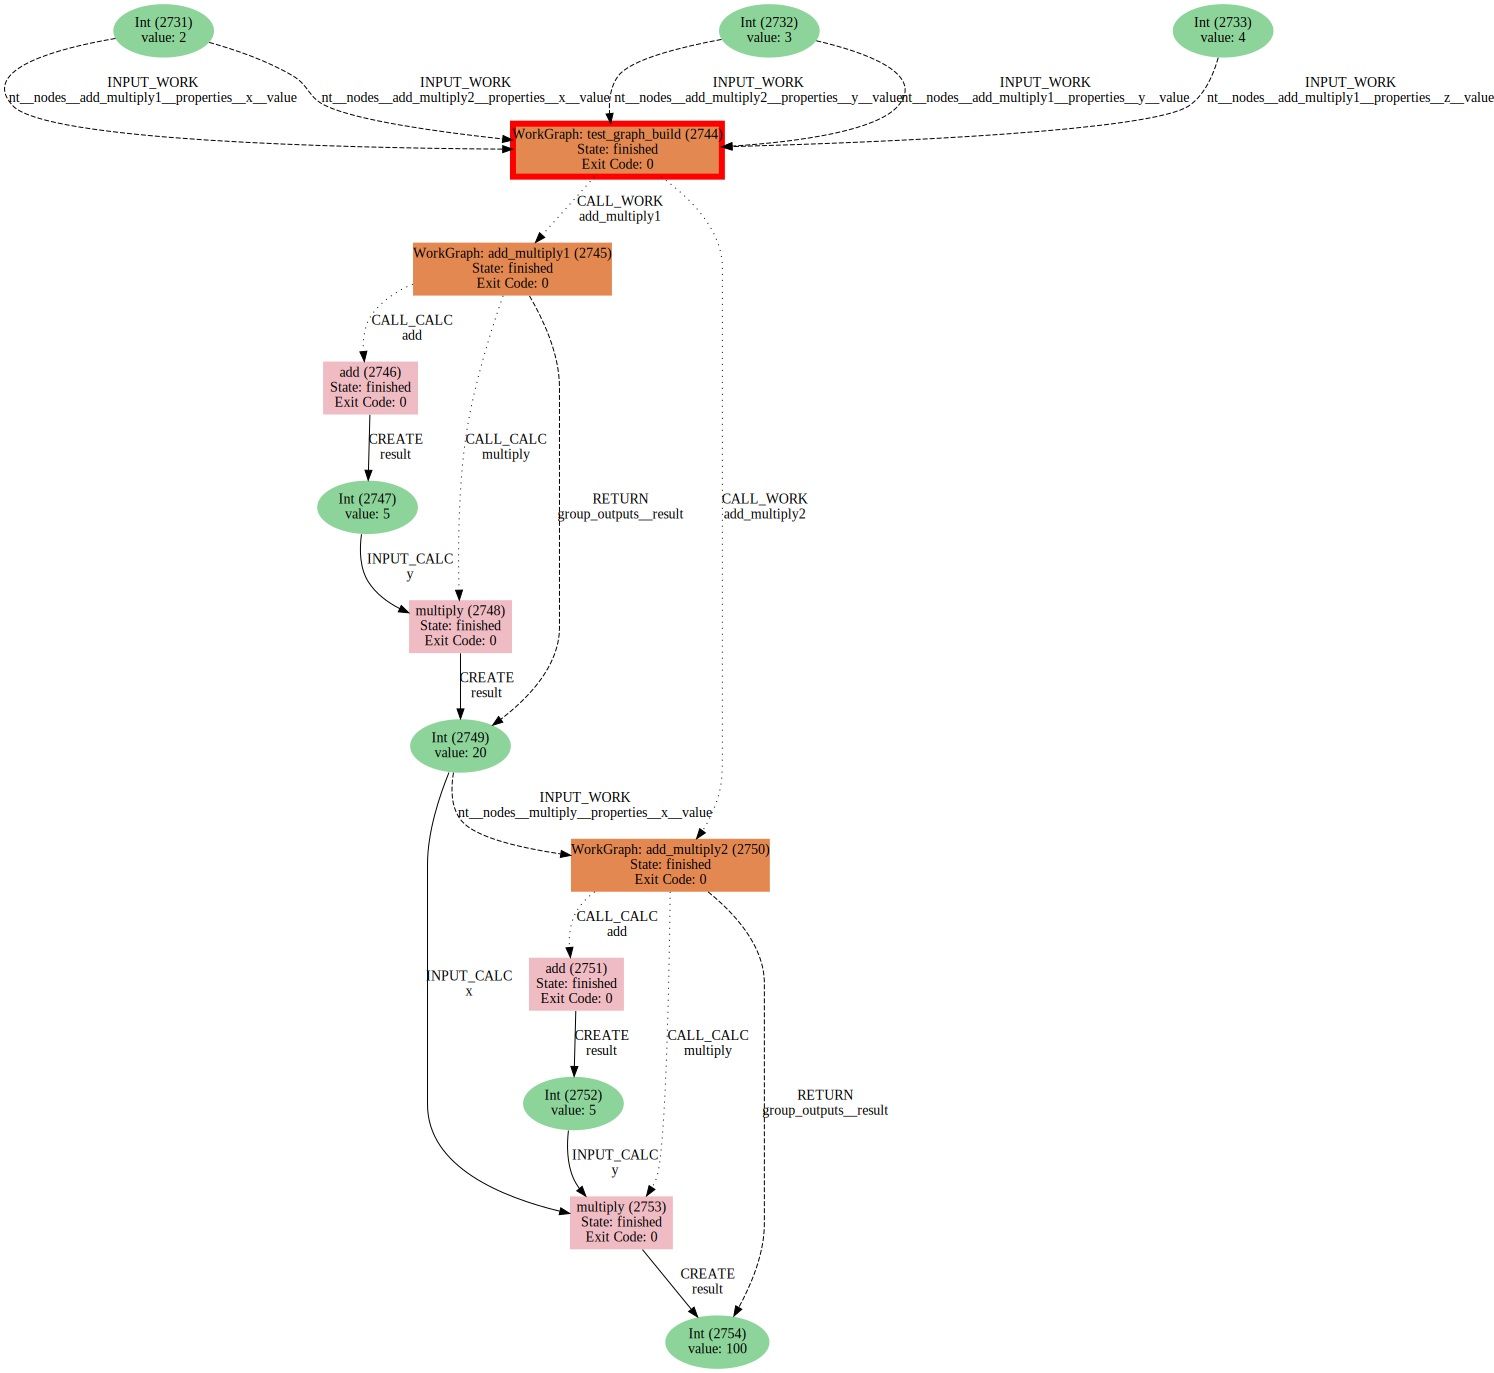

In [ ]:
generate_node_graph(wg.pk)

### Start the web server
Worktree also provides a web GUI, where you can view and manage the workgraph. Open a terminal, and run:
```
workgraph web start
```
Then visit the page http://127.0.0.1:8000/workgraph, you can view the workgraph later from here. You should find all the submited workgraph, e.g., the `first_workflow` Worktree. Please click the pk and view the workgraph.

## What's Next

|        |                                         |
|---------------|----------------------------------------------------|
| [Concepts](concept/index.rst)                          | A brief introduction of WorkGraph’s main concepts.  |
| [Tutorials](tutorial/index.rst)                        | Real-world examples in computational materials science and more.                     |
| [HowTo](howto/index.rst)                              | Advanced topics and tips, e.g flow control using `if`, `for`, `while` and `context`.    |